# A simple adapted model for looking at price impact of expensive houses #

Let us assume the housing market can be modelled by a simple supply and demand model. For a given price, there will be a number of buyers and sellers. If the price is high, there will be more sellers and less buyers, and if the price is low, there will be more buyers and less sellers. 

Let us also assume that every house being sold is equal in every way whatsoever. This is a very unrealistic assumption but it is needed for the subsequent analysis. We also introduce the variables being used in the analysis here:

Number of potential buyers: $N$.

Volume of people willing to buy: $V$.

$V$ will be a function of the price $p$. It has its maximum as $N$ and minimum as $0$. 

For each buyer in the $N$ buyers, the buyer will have a maximum price $p^\prime$ that he is willing to pay for the house. We can form a distribution for $p^\prime$. We call the PDF of this distribution $\chi_b(p^\prime)$. The properties of this distribution is that it only has support on $[0,p_{max}]$, where $p_{max}$ is the *maximum possible price*, or in other words, the maximum price one can sell a house at that at least $1$ buyer of the $N$ potential buyers is willing to pay for.


In [1]:
import scipy as scp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

For example, if $p_{max}$ is $1$, and the distribution is uniform, a graph of the PDF would look like this:

Text(0, 0.5, 'PDF')

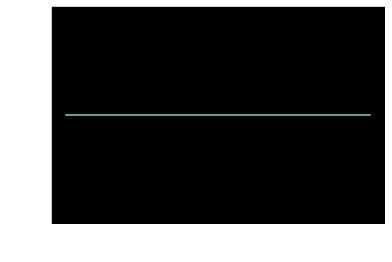

In [2]:
plt.plot(np.linspace(0,1,11),[1]*11)
plt.xlabel('p')
plt.ylabel('PDF')

For a given price $p$, the number of people willing to buy $V(p)$ is given as:

$$
V(p) = N(1-\int_0^p \chi_b(p^\prime)d p^\prime).
$$

which is really a function of the CDF of the distribution. For the above distribution, if $N=100$, $V(p)$ is then:

Text(0, 0.5, 'V(p)')

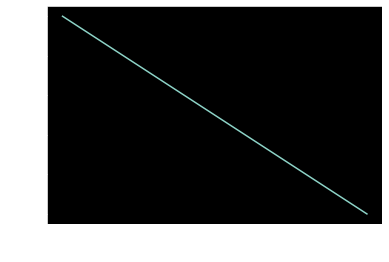

In [3]:
plt.plot(np.linspace(0,1,101),100*(1-np.linspace(0,1,101)))
plt.xlabel('p')
plt.ylabel('V(p)')

Now let us model the number of sellers in a similar way. 

Number of potential sellers: $S$

Volume of people wanting to sell: $Q$

$Q$ is a function of the price $p$, with maximum $S$ and minimum $0$.

For each seller in $S$, there is a minimum price $p^\prime$ that he is willing to sell his house for. This can form a distribution $\chi_s(p^\prime)$. For a given price $p$, the number of people willing to sell $Q(p)$ is given as:

$$
Q(p) = S \int_0^p \chi_b(p^\prime)d p^\prime.
$$

If $S=100$, $p_{max}=1$, and we assume distribution for $\chi_s$ is uniform, we show a plot of $Q(p)$:

Text(0, 0.5, 'Q(p)')

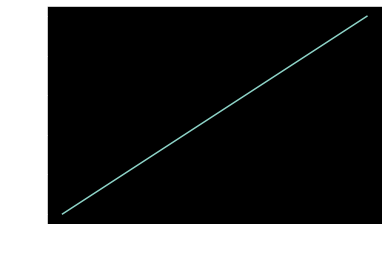

In [4]:
plt.plot(np.linspace(0,1,101),100*(np.linspace(0,1,101)))
plt.xlabel('p')
plt.ylabel('Q(p)')

Let us place the 2 curves on the same plot

Text(0.5, 0, 'p')

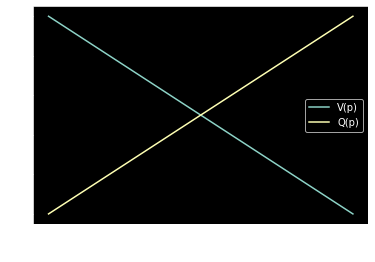

In [5]:
plt.plot(np.linspace(0,1,101),100*(1-np.linspace(0,1,101)),label='V(p)')
plt.plot(np.linspace(0,1,101),100*(np.linspace(0,1,101)),label='Q(p)')
plt.legend()
plt.xlabel('p')

The p where they intercept is the point where there are equal numbers of buyers and sellers, which is traditionally known as the equilibrium price, where demand and supply intersect. Let us call this $p_e$. 

## Goal ##

Our goal now is to see how this equilibrium price $p_e$ changes, as the distribution of the buyers changes. This is simply finding the point $p$ such that $V(p)=Q(p)$. 

The distribution will be chosen such that it models certain things we want to add into the model. I will compare 2 scenarios:

1. An approximately gaussian distribution for both $\chi_b$ and $\chi_s$, for equal number of potential buyers $N$ and sellers $S$. This is approximately gaussian as we cannot make a true gaussian distribution with support in a limited range. 

2. The same as above, but now we add in a small number of buyers $\epsilon$. These new buyers are all close to $p_{max}$. This is to simulate the effect of a few extremely rich buyers entering the market. 

We want to see how $p_e$ changes as a response to $\epsilon$. 

This will be done numerically. It is possible to do this analytically with some further approximations (mainly on using proper gaussian distributions, assuming the tails of the gaussian die off fast enough so that the contributions outside the desired range are negligible, allowing us to take integrals from minus to positive infinity to evaluate the gaussian), but since I am lazy and this isnt my full time job I wont do so.

#### Scenario 1 ####

Let us assume $N=S=100,000$, with $p_{max}=1000$. Let us also choose approximate gaussians extremely centered around $p=500$.

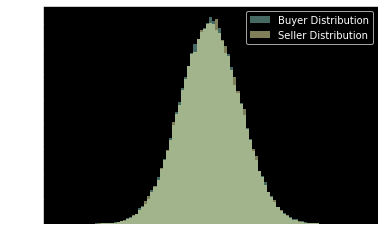

In [6]:
N = 100000
pmax = 1000
buyermean = 500
buyerstdev = 100
numberofbins = 100
buyerdistribution = []
while len(buyerdistribution)<N:
    n = np.random.normal(buyermean,buyerstdev)
    if n>0 and n<=pmax:
        buyerdistribution.append(n)

def plot_histogram(data,numberofbins,label,minimum,maximum):
    bins = np.linspace(minimum, maximum, numberofbins)
    bin_probabilities = np.histogram(data,bins)[0]/len(data)
    leftedges = bins[:-1]
    rightedges = bins[1:]
    widths = np.array(rightedges)-np.array(leftedges)
    plt.bar(leftedges,bin_probabilities,width=widths,align='edge',label=label,alpha=0.5)
    binmidvalues = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

S = 100000
sellermean = 500
sellerstdev = 100
sellerdistribution = []
while len(sellerdistribution)<N:
    n = np.random.normal(sellermean,sellerstdev)
    if n>0 and n<=pmax:
        sellerdistribution.append(n)
plot_histogram(buyerdistribution,numberofbins,'Buyer Distribution',0,pmax)
plot_histogram(sellerdistribution,numberofbins,'Seller Distribution',0,pmax)
plt.legend()


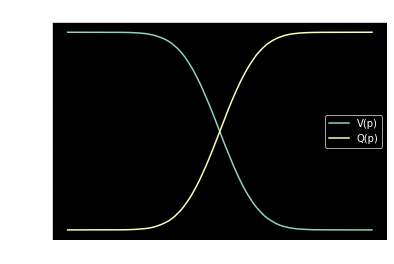

In [7]:
cdf_number_ps = 10001
def get_CDF_manual(data,pmax,numbersteps):
    npdata = np.array(data)
    totalnumberdata = len(npdata)
    ps = np.linspace(0,pmax,numbersteps)
    cdf = []
    for p in ps:
        filter_array = npdata<p
        filt_data = npdata[filter_array]
        cdf.append(len(filt_data)/totalnumberdata)
    return np.array(cdf)
buyer_cdf = get_CDF_manual(buyerdistribution,pmax,cdf_number_ps)
seller_cdf = get_CDF_manual(sellerdistribution,pmax,cdf_number_ps)
Vs = N*(1-buyer_cdf)
Qs = S*(seller_cdf)
differences = np.abs(Vs-Qs)
pe = np.linspace(0,pmax,cdf_number_ps)[differences.argmin()]
plt.plot(np.linspace(0,pmax,cdf_number_ps),Vs,label='V(p)')
plt.plot(np.linspace(0,pmax,cdf_number_ps),Qs,label='Q(p)')
plt.title('p_e = %s'%(pe))
plt.legend()

As we can see, $p_e$ is $499.9$, or approximately $500$, which is what we would expect for the equilibrium price, if the number of buyers and sellers is equal and their distributions are both gaussian and centered on $500$.

#### Scenario 2 ####

Now let us add a number of rich buyers into the system. Let us add 1000 rich buyers, which is $1\%$ of the prior number of buyers. Let us also assume that these buyers are drawn from a gaussian distribution centered on $900$, with standard deviation $25$. This indicates that the majority of them are prepared to spend $900 \pm 25$ dollars on the house.

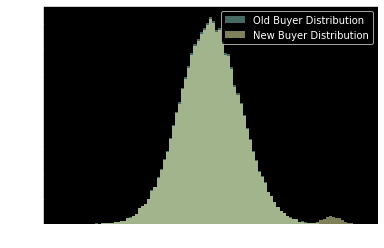

In [21]:
N_new = 1000
newbuyermean = 900
newbuyerstdev = 25
newbuyerdistribution = []

while len(newbuyerdistribution)<(N_new):
    n = np.random.normal(newbuyermean,newbuyerstdev)
    if n>0 and n<=pmax:
        newbuyerdistribution.append(n)
newbuyerdistribution = np.append(buyerdistribution,np.array(newbuyerdistribution))

plot_histogram(buyerdistribution,numberofbins,'Old Buyer Distribution',0,pmax)
plot_histogram(newbuyerdistribution,numberofbins,'New Buyer Distribution',0,pmax)
plt.legend()

As can be seen, now there is a small bump in the new buyer distribution around $900$, showing the presence of these new buyers that are willing to spend around $900$ for the house. Now let us calculate $p_e$.

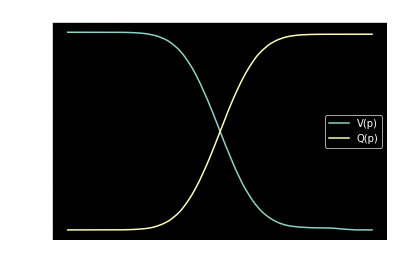

In [22]:
buyer_cdf = get_CDF_manual(newbuyerdistribution,pmax,cdf_number_ps)
seller_cdf = get_CDF_manual(sellerdistribution,pmax,cdf_number_ps)
Vs = (N+N_new)*(1-buyer_cdf)
Qs = (S)*(seller_cdf)
differences = np.abs(Vs-Qs)
pe = np.linspace(0,pmax,cdf_number_ps)[differences.argmin()]
plt.plot(np.linspace(0,pmax,cdf_number_ps),Vs,label='V(p)')
plt.plot(np.linspace(0,pmax,cdf_number_ps),Qs,label='Q(p)')
plt.title('p_e = %s'%(pe))
plt.legend()

It seems that the equilibrium price $p_e$ changed to $501$. That is a $0.2 \%$ increase, which is somewhat unexpected since we added $ 1 \% $ of new rich buyers. Now let us do similar calculations for adding in percentages of new rich buyers between $ 0 \% - 50\%$, and see how much the corresponding increase in $p_e$ is.

In [23]:
percentagemax = 0.5
percentages = np.linspace(0,percentagemax,500)
percentage_increase_pmax = []
from tqdm.notebook import tqdm_notebook

for i in tqdm_notebook(range(len(percentages))):
    per = percentages[i]
    number_new_buyers = int(per*N)
    newbuyerdistribution = []
    while len(newbuyerdistribution)<(number_new_buyers):
        n = np.random.normal(newbuyermean,newbuyerstdev)
        if n>0 and n<=pmax:
            newbuyerdistribution.append(n)
    newbuyerdistribution = np.append(buyerdistribution,np.array(newbuyerdistribution))
    buyer_cdf = get_CDF_manual(newbuyerdistribution,pmax,cdf_number_ps)
    Vs = (N+number_new_buyers)*(1-buyer_cdf)
    Qs = S*(seller_cdf)
    differences = np.abs(Vs-Qs)
    pe = np.linspace(0,pmax,cdf_number_ps)[differences.argmin()]
    percentage_increase_pmax.append((pe-500)/500)

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0, 0.5, 'Percentage increase in equilibrium price')

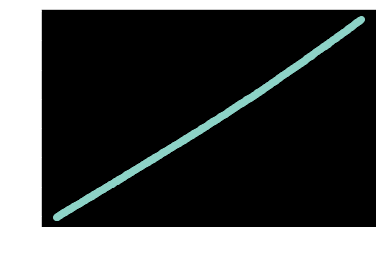

In [24]:
percentage_increase_pmax = np.array(percentage_increase_pmax)
plt.plot(percentages*100,percentage_increase_pmax*100,'o')
plt.xlabel('Percentage of new rich buyers')
plt.ylabel('Percentage increase in equilibrium price')

It seems like the addition of new buyers does not affect the equilibrium price by as much as we expect. Even adding in $ 50 \% $ rich buyers, the equilibrium price only increases by $14 \% $.